# CROSS VALIDATION: IMPLEMENTATION

This notebook describes how to do cross validation for simulation models.

Cross validation partitions the observed data into *folds*.
A fold consists of a pair of training data and test data.
For simulation models,
the training data are used to estimate parameters, and the quality of these estimates is evaluated based on predictions of the test data.

The main challenges with cross validation for simulation data are: creating folds, estimating parameters on data subsets, and evaluating parameter estimates on a data subset.

# Programming Preliminaries

In [37]:
IS_COLAB = True

In [38]:
if IS_COLAB:
    !pip install -q tellurium
    !pip install -q SBstoat
    pass

In [39]:
%matplotlib inline
import tellurium as te
import numpy as np
import math
import random 
import matplotlib.pyplot as plt
from SBstoat import ModelFitter, NamedTimeseries, Parameter

In [40]:
import urllib
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, 

In [41]:
def findCloseMatchingValues(longArr, shortArr):
    """
    Finds the indices in longArr that are closest to the values in shortArr.

    Parameters
    ----------
    longArr: np.array
    shortArr: np.arry

    Returns
    -------
    array-int
    """
    indices = []
    for val in shortArr:
        distances = (longArr - val)**2
        minDistance = np.min(distances)
        distancesLst = list(distances)
        idx = distancesLst.index(minDistance)
        indices.append(idx)
    return np.array(indices)

# TESTS
longArr = np.array(range(10))
shortArr = np.array([2.1, 2.9, 4.3])
indexArr = findCloseMatchingValues(longArr, shortArr)
expectedArr = [2, 3, 4]
assert(all([v1 == v2 for v1, v2 in zip(indexArr, expectedArr)]))

In [42]:
# Experimental conditions
END_TIME = max(LINEAR_PATHWAY_ARR[:, 0])
NUM_POINT = 15
NOISE_STD = 1.0
NUM_FOLD = 3
#FITTED_DATA = runSimulation(parameterDct={"k1": 0.1}, numPoint=numPoint)

In [43]:
def runSimulation(simTime=END_TIME, numPoint=NUM_POINT, roadRunner=None,
                  parameterDct=None, model=LINEAR_PATHWAY_MODEL):
    """
    Runs the simulation model for the parameters.
   
    Parameters
    ----------
    endTime: float
        End time for the simulation
    numPoints: int
        Number of points in the simulation
    roadRunner: ExtendedRoadRunner
    parameters: list-str
        
    Returns
    -------
    NamedArray
        results of simulation
    """
    if roadRunner is None:
        roadRunner = te.loada(model)
    else:
        roadRunner.reset()
    if parameterDct is not None:
        # Set the simulation constants for all parameters
        for name in parameterDct.keys():
            roadRunner[name] = parameterDct[name]
    return roadRunner.simulate (0, simTime, numPoint)

# TESTS
numPoint = int(10*END_TIME)
fittedData = runSimulation(parameterDct={"k1": 0.1}, numPoint=numPoint)
numCol = np.shape(fittedData)[1]
assert(np.size(fittedData) == numPoint*numCol)
assert(fittedData[0, 1] == 10)

## Constants

In [44]:
# Constants
FOLD_TRAINING = 0 # Training data in a fold
FOLD_TEST = 1 # Test data in a fold
RSQ = "rsq" # R-squared value in a dataframe

# Model

In [45]:
print(LINEAR_PATHWAY_MODEL)

R1:  S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S2
R3: S3 -> S4; k3*S3
R4: S4 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
k3 = 0; # Nominal value of parameter
k4 = 0; # Nominal value of parameter



# Cross Validation Algorithm

Cross validation divides the data into training and test sets.
The training sets are used to estimate parameters.
The test sets are used to evaluate the quality of the
parameter fits.
That is, for each set of test indices, we have a companion set of training indices. The training indices select a subset of the observational data that are used to estimate parameter values.

Below is pseudo code that calculates the $R^2$ value for each fold.

    def crossValidate(model, observedData, numFold):
        folds = generateFolds(observedData, numFold)
        foldQualities = []
        for fold_train, fold_test in folds:
            parameterEstimates = fitModel(model, fold_train)
            foldQuality = evaluateFold(model, parameterEstimates, fold_test)
            foldQualities.append(foldQuality)
        return foldQualities

# Generating Folds

The first step is to generate the folds.
A fold is represented by a tuple.
The first element is the training data;
the second element is the test data.
The collection of these tuples is itsself an array.
``generateFolds`` such an array.



In [46]:
def generateFolds(observedData, numFold):
    """
    Generates indices of training and test data
    by alternating between folds
    
    Parameters:
    ----------
    observedData: np.array(N, M) or NamedTimeseries
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    array-tuple(array, array)
    """
    if isinstance(observedData, NamedTimeseries):
        df = observedData.to_dataframe()
        df = df.reset_index()
        observedData = df.to_numpy()
    result = []
    numPoint, numCol = np.shape(observedData)
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = np.array([n for n in indices if n % numFold == remainder])
        testData = observedData[testIndices, :]
        trainIndices = np.array(list(set(indices).difference(testIndices)))
        trainData = observedData[trainIndices, :]
        entry = (trainData, testData)
        result.append(entry)
    return result

# TESTS
numFold = 3
observedData = NamedTimeseries(dataframe=LINEAR_PATHWAY_DF)
folds = generateFolds(observedData.to_dataframe().to_numpy(), numFold)
assert(len(folds) == numFold)
fold = folds[0]
assert(len(fold) == 2)
trainData = fold[0]
testData = fold[1]
assert(len(observedData) == (len(trainData) + len(testData)))
#
fold2s = generateFolds(observedData, numFold)
assert(len(folds) == len(fold2s))

# Estimate Parameters and Evaluate Folds

In [47]:
def estimateParameters(model, colnames, parametersToFit, trainingData,
                 **fittingArgs):
    """
    Finds the parameters that fit the fold.

    Parameters
    ----------
    model: antimony/ExtendedRoadRunner
    colnames: list-str
        names of data columns
    trainingData: np.array
    fittingArgs: dict
        optional arguments for ModelFitter

    Returns
    -------
    dict
        key: parameter name
        value: parameter value
    """
    # Estimate the parameters
    observedTS = NamedTimeseries(colnames=colnames, array=trainingData)
    fitter = ModelFitter(modelSpecification=model,
                                    parametersToFit=parametersToFit,
                                    observedData=observedTS,
                                    **fittingArgs,
                                    )
    fitter.fitModel()
    return dict(fitter.params.valuesdict())

# TESTS
model = te.loada(LINEAR_PATHWAY_MODEL)
colnames = list(LINEAR_PATHWAY_DF.columns)
parametersToFit = [
                Parameter("k1", lower=0, value=0, upper=10),
                Parameter("k2", lower=0, value=0, upper=10),
                Parameter("k3", lower=0, value=0, upper=10),
                Parameter("k4", lower=0, value=0, upper=10),
    ]
folds = generateFolds(LINEAR_PATHWAY_ARR, NUM_FOLD)
fold = folds[0]
parameterDct = estimateParameters(model, colnames, parametersToFit,
                                fold[FOLD_TRAINING],
                                fitterMethods=["differential_evolution"])
assert(isinstance(parameterDct, dict))

In [48]:
def evaluateFold(model, parameterDct, testData):
    """
    Calculates the R-squared value for the fit of the predicted test data for
    the values of the model parameters that are provided.

    Parameters
    ----------
    model: antimony/ExtendedRoadRunner
    parameterDct: dict
        key: str (parameter name)
        value: float (parameter value)
    testData: np.array

    Returns
    -------
    float: R squared
    ModelFitter
    """
    endTime = END_TIME
    numPoint = int(10*endTime)
    fittedData = runSimulation(simTime=endTime, numPoint=numPoint,
                                parameterDct=parameterDct,
                                roadRunner=model)
    # Find the time indices that correspond to the test data
    testTimes = testData[:, 0]
    fittedTimes = fittedData[:, 0]
    indices = findCloseMatchingValues(fittedTimes, testTimes)
    # Calculate residuals for the corresponding times
    indexArr = np.array(indices)
    fittedTestData = fittedData[indexArr, 1:]
    flatFittedTestData = fittedTestData.flatten()
    flatTestData = (testData[:, 1:]).flatten()
    residualsArr = flatTestData - flatFittedTestData
    rsq = 1 - np.var(residualsArr)/np.var(flatTestData)
    #
    return rsq

# TESTS
model = te.loada(LINEAR_PATHWAY_MODEL)
colnames = list(LINEAR_PATHWAY_DF.columns)
parametersToFit = [
                Parameter("k1", lower=0, value=0, upper=10),
                Parameter("k2", lower=0, value=0, upper=10),
                Parameter("k3", lower=0, value=0, upper=10),
                Parameter("k4", lower=0, value=0, upper=10),
    ]
folds = generateFolds(LINEAR_PATHWAY_ARR, NUM_FOLD)
fold = folds[0]
parameterDct = estimateParameters(model, colnames, parametersToFit, 
                                  fold[FOLD_TRAINING],
                                  fitterMethods=["differential_evolution"])
rsq = evaluateFold(model, parameterDct, fold[FOLD_TEST])
assert(rsq > 0.85)

# Complete Workflow

In [49]:
def crossValidate(model, observedData, parametersToFit, colnames, numFold,
                  **fitterArgs):
    """
    Performs cross validation on the model.

    Parameters
    ----------
    model: ExtendedRoadrunner
    observedData: NamedTimeseries
    parametersToFit: list-SBstoat.Parameter
    colnames: list-str
    numFold: int

    Results
    -------
    pd.DataFrame
        Index: fold
        Columns
            R2: R squared value
            values of parameters
    """
    folds = generateFolds(observedData, numFold)
    resultDct = {p.name: [] for p in parametersToFit}
    resultDct[RSQ] = []
    for fold in folds:
        parameterDct = estimateParameters(model, colnames, parametersToFit,
                   fold[FOLD_TRAINING],
                   fitterMethods=["differential_evolution"])
        rsq = evaluateFold(model, parameterDct, fold[FOLD_TEST])
        resultDct[RSQ].append(rsq)
        for parameter in parametersToFit:
            resultDct[parameter.name].append(parameterDct[parameter.name])
    df = pd.DataFrame(resultDct)
    return df

# TESTS
model = te.loada(LINEAR_PATHWAY_MODEL)
colnames = list(LINEAR_PATHWAY_DF.columns)
parametersToFit = [
                Parameter("k1", lower=0, value=0, upper=10),
                Parameter("k2", lower=0, value=0, upper=10),
                Parameter("k3", lower=0, value=0, upper=10),
                Parameter("k4", lower=0, value=0, upper=10),
    ]
observedData = NamedTimeseries(dataframe=LINEAR_PATHWAY_DF)
resultDF = crossValidate(model, observedData, parametersToFit,
                          colnames, NUM_FOLD,
                          fitterMethods=["differential_evolution"])
trues = [q > 0.85 for q in resultDF[RSQ]]
assert(all(trues))

In [63]:
model = te.loada(LINEAR_PATHWAY_MODEL)
colnames = list(LINEAR_PATHWAY_DF.columns)
parametersToFit = [
                Parameter("k1", lower=0, value=0, upper=10),
                Parameter("k2", lower=0, value=0, upper=10),
                Parameter("k3", lower=0, value=0, upper=10),
                Parameter("k4", lower=0, value=0, upper=10),
    ]
observedData = NamedTimeseries(dataframe=LINEAR_PATHWAY_DF)
resultDF = crossValidate(model, observedData, parametersToFit,
                          colnames, 30,
)
#                         fitterMethods=["differential_evolution"])
resultDF

,k1,k2,k3,k4,rsq
0,1.089391,2.263982,3.213642,4.491671,0.8006363619174209
1,1.001280,2.171962,3.123484,4.341648,0.8874247766929391
2,1.004116,2.161353,3.110239,4.327952,0.8177185274238501
3,1.003126,2.160151,3.096908,4.324623,0.8277551513534258
4,0.999915,2.175063,3.120232,4.349206,0.8531480478943125
5,1.010703,2.158461,3.096145,4.294680,0.8590911044627392
6,0.999794,2.167281,3.097559,4.329570,0.8850148625743144
7,1.002298,2.187457,3.098221,4.322219,0.8643060088606436
8,1.006190,2.157034,3.129971,4.362049,0.8846035829217137
9,1.003384,2.162520,3.106976,4.378797,0.8654089363834696


In [50]:
resultDF

,k1,k2,k3,k4,rsq
0,1.067128,2.266268,3.098546,4.675938,0.86163332047915
1,1.012530,2.241224,3.162879,4.218408,0.8819547129247662
2,1.021862,2.059656,3.071087,4.111237,0.8867234151638236


# Exercises

This exerise uses the ``WOLF_MODEL`` and the data ``WOLF_DF``.
Only fit the parameters ``J1_k1``, ``J1_ki``, and ``J1_n``.

1. Do 2, 10, 20, and 100 fold cross validations. Save the fold qualities in a python dictionary.

1. Some questions about the results in (1).
   1. How does the mean value of quality change with the number of folds?

   1. Can you explain the trend in the standard deviations of the quality scores?

1. Plot the distribution of quality scores for 20 and 100 folds.
What can you say about these distributions?
   1. Hint: If ``resultDF`` is the DataFrame returned by ``crossvalidate``,
   then ``list(resultDF[RSQ])`` is the list of $R^2$ values for the folds.


## (1) Calculate Cross Validations

In [51]:
model = te.loada(WOLF_MODEL)
colnames = list(WOLF_DF.columns)
observedData = NamedTimeseries(dataframe=WOLF_DF)

In [52]:
parametersToFit = [
      Parameter("J1_k1", lower=0, value=1, upper=1100), #550
      Parameter("J1_Ki", lower=0, value=1, upper=2), #1
      Parameter("J1_n", lower=0, value=1, upper=8), #4                                                                                                                                                                 
]

In [53]:
resultDct = {}
for numFold in [2, 10, 20]:
    qualityDF = crossValidate(model, observedData, parametersToFit,
                          colnames, numFold,
                          fitterMethods=["differential_evolution"],
                          endTime=5)
    resultDct[numFold] = qualityDF


5486.888461:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

5487.244171:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

5497.422605:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

5504.748356:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual dou

## (2) Questions

1. The mean values of $R^2$ change little as the folds increase, although there is a small decrease at 100 folds.
1. The standard deviation of $R^2$ increases with the number of folds.
This is because with fewer data values in the test data,
there is more variability in how well the model fits.

## (3) Plot the distributions

In [54]:
def plotHist(numFold):
    """
    Plots a histogram for the number of folds.

    Parameters
    ----------
    numFold: int
    """
    _ = plt.hist(resultDct[numFold][RSQ])
    plt.xlim([0, 1.0])
    plt.title("Folds: %d" % numFold)
    plt.xlabel("R-squared")

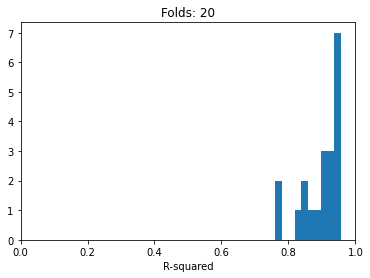

In [55]:
plotHist(20)

The histogram plots are consistent with the observation that variance increases with the number of folds.

# Cross Validation with SBMLLint


6446.241716:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6446.567682:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6446.875834:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6447.020171:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual dou

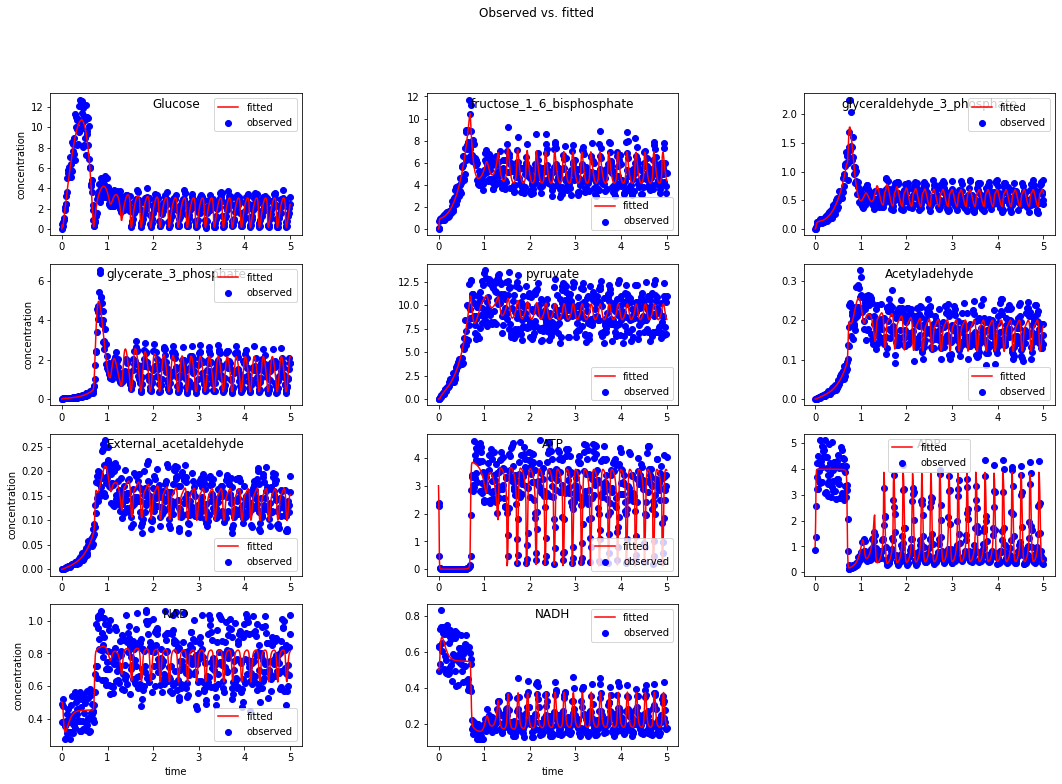

In [56]:
model = te.loada(WOLF_MODEL)
observedData = NamedTimeseries(dataframe=WOLF_DF)
#
fitter = ModelFitter(model, observedData, parametersToFit=parametersToFit)
fitter.fitModel()
print(fitter.reportFit())
fitter.plotFitAll(figsize=(18, 12), color=["red", "blue"], numCol=3)

In [57]:
fitter.crossValidate(numFold=3)

Folds:   0%|          | 0/4 [00:00<?, ?it/s]


6484.207254:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6484.255127:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6484.280521:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6484.449922:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual dou

Folds:  25%|██▌       | 1/4 [00:40<02:00, 40.19s/it]


6524.034504:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6524.736965:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6547.246334:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

6547.266472:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual dou

Folds: 100%|██████████| 4/4 [01:05<00:00, 16.34s/it]


In [58]:
fitter.cvRsqs

[0.9542079253686435, 0.9458244714442319, 0.9515914168149981]

In [59]:
fitter.parameterDF

,mean,std,count
parameter,,,
J1_Ki,0.964240,0.082490,3
J1_k1,661.167153,215.928642,3
J1_n,4.000174,0.032022,3
